In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    syllable_aliases,
    savefig
)
from rl_analysis.util import rle, count_transitions
from rl_analysis.io.df import get_closed_loop_parquet_columns
import pandas as pd

import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
figure_cfg = analysis_config["figures"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]

In [5]:
learners = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)["snc (axon)"]["learners"]

# Load in raw data and normalize

In [7]:
fname = os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet")
cols = get_closed_loop_parquet_columns(fname, pcs=False, likes=False) 

In [8]:
feedback_df = pd.read_parquet(
    fname,
    filters=[
        ("experiment_type", "=", "reinforcement"),
        ("area", "in", ["snc (axon)", "ctrl"]),
    ],
    columns=cols,
).sort_index()
feedback_df = feedback_df.loc[
    (feedback_df["opsin"].isin(["chr2", "ctrl"]))
    & (feedback_df["stim_duration"] == 0.25)
].copy()

In [9]:
feedback_df["syllable_number"] = feedback_df.groupby("uniq_id")[
    "predicted_syllable"
].transform(lambda x: (x.diff() != 0).cumsum())

feedback_df["is_feedback"] = (feedback_df["feedback_status"] > 0) & (
    feedback_df["session_number"].isin([1, 2])
)
feedback_df["is_catch"] = (feedback_df["feedback_status"] == 0) & (
    feedback_df["session_number"].isin([1, 2])
)
is_feedback = feedback_df.groupby(["uniq_id", "syllable_number"])["is_feedback"].any()
is_catch = feedback_df.groupby(["uniq_id", "syllable_number"])["is_catch"].any()

In [10]:
rle_df = feedback_df.groupby("uniq_id")["predicted_syllable"].apply(rle)
rle_df.index = rle_df.index.droplevel(0)

In [11]:
rle_df = feedback_df.loc[rle_df.index]

In [12]:
all_duration = rle_df.groupby("uniq_id")["timestamp"].shift(-1) - rle_df["timestamp"]
rle_df["duration"] = (
    rle_df.groupby("uniq_id")["timestamp"].shift(-1) - rle_df["timestamp"]
)

In [13]:
rle_df["learner"] = rle_df["mouse_id"].isin(learners)
rle_df["learner"] = rle_df["learner"].map({True: "yes", False: "no"})
rle_df.loc[rle_df["area"] == "ctrl", "learner"] = "ctrl"

In [14]:
rle_df.loc[rle_df["mouse_id"].str.contains("dls-ai32jr"), "area"] = "snc (axon)"

In [15]:
rle_df = rle_df.set_index(is_feedback.index.names)

In [16]:
rle_df = rle_df.sort_index()
is_feedback = is_feedback.sort_index()
is_catch = is_catch.sort_index()

In [17]:
rle_df = rle_df.reset_index()

In [18]:
# 1: count transitions
# 2: rank transitions at baseline
# 3: show transition change above baseline values...

In [19]:
tms = rle_df.groupby(
    ["area", "mouse_id", "learner", "target_syllable", "session_number", "uuid"],
    observed=True,
)["predicted_syllable"].apply(lambda x: count_transitions(x, K=100))

In [20]:
tms = tms.loc[tms.index.get_level_values("area").isin(["ctrl", "snc (axon)"])]

In [21]:
def slice_tm(tm, idx, axis=1):
    if axis == 1:
        return tm[idx].ravel()
    else:
        return tm[:, idx].ravel()

In [22]:
def reorder_vec(vec, order):
    return vec[order]

In [23]:
usage = rle_df["predicted_syllable"].value_counts(normalize=True)

In [24]:
chk_syllables = usage.index[:36]
chk_syllables = list(syllable_aliases.keys())

In [25]:
trans_lst = []
for _target in tqdm(chk_syllables):
    out_trans = (
        tms.apply(lambda x: slice_tm(x, _target, axis=1)).rename("p").reset_index()
    )
    out_trans["type"] = "out"
    in_trans = (
        tms.apply(lambda x: slice_tm(x, _target, axis=0)).rename("p").reset_index()
    )
    in_trans["type"] = "in"

    # the following line reorders HERE
    all_trans = pd.concat([out_trans, in_trans])
    all_trans["syllable"] = _target
    all_trans["is_target"] = all_trans["syllable"] == all_trans["target_syllable"]
    trans_lst.append(all_trans)

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
trans_df = pd.concat(trans_lst).reset_index()
trans_df = trans_df.loc[trans_df["is_target"]].copy().drop("syllable", axis=1)
exclude_target_vec = np.ones((100,))
# exclude_target_vec[list(syllable_aliases.keys())] = 0
baseline_sorting = (
    trans_df.loc[trans_df["session_number"].isin([-1, 0])]
    .groupby(["mouse_id", "target_syllable", "type"])["p"]
    .sum()
    .apply(lambda x: np.argsort(x * exclude_target_vec)[::-1])
    .rename("order")
)
trans_df = (
    trans_df.set_index(baseline_sorting.index.names)
    .join(baseline_sorting)
    .reset_index()
)
trans_df["p"] = trans_df.apply(lambda x: x["p"][x["order"]], axis=1)

In [27]:
trans_df["session_type"] = "n/a"
trans_df.loc[trans_df["session_number"].isin([-1, 0]), "session_type"] = "baseline"
trans_df.loc[trans_df["session_number"].isin([1, 2]), "session_type"] = "stim"
trans_df.loc[trans_df["session_number"].isin([3, 4]), "session_type"] = "post-stim"

In [28]:
try:
    trans_df_split = trans_df["p"].apply(pd.Series)
except KeyError:
    pass

index_df = trans_df.drop(["p", "order"], axis=1)
new_index_keys = [
    _ for _ in index_df.columns.tolist() if ("p_" not in _) and ("order" not in _)
]
trans_df = index_df.join(trans_df_split)

In [29]:
trans_df = trans_df.set_index(new_index_keys)

In [30]:
trans_df = trans_df.melt(ignore_index=False, var_name="transition_rank")

In [31]:
use_df = trans_df.groupby(
    [
        "area",
        "mouse_id",
        "learner",
        "type",
        "session_number",
        "session_type",
        "is_target",
        "target_syllable",
        "transition_rank",
    ]
)["value"].sum()

In [32]:
from sklearn.utils import resample

In [33]:
setup_plotting_env()

In [35]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "syllable_stats_online.toml")
)

post_mean = (
    trans_df.loc[trans_df["transition_rank"] <= syllable_stats["truncate"]]
    .groupby(["type", "mouse_id", "learner", "session_type", "transition_rank"])
    .mean()
)
post_mean_norm = post_mean.groupby("mouse_id").transform(lambda x: x / x.sum())

In [36]:
use_stat = "fold"

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

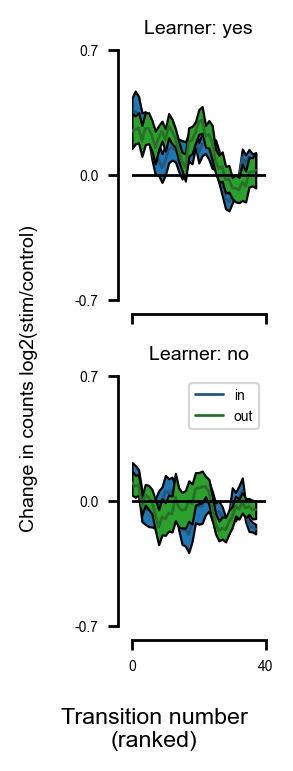

In [37]:
eps = 1.
nboots = 1000

fig, ax = plt.subplots(2, 1, figsize=(1.4, 3.8), sharex=True, sharey=True)
colors = [sns.color_palette()[0], sns.color_palette()[2]]
for _learner, _ax in zip(["yes", "no"], ax):
    handles = []
    zorder = 0
    for _diff, _color in zip(["in", "out"], colors):
        use_colors = sns.dark_palette(_color)
        fc, lc = use_colors[-1], use_colors[-3]
        diffs = []
        for _boot in tqdm(range(nboots)):
            _tmp1 = (
                post_mean.xs(
                    (_diff, _learner, "post-stim"),
                    level=("type", "learner", "session_type"),
                )
                + eps
            )
            _tmp1 = _tmp1.groupby("mouse_id").rolling(5, 1, True).mean()
            _tmp2 = (
                post_mean.xs(
                    (_diff, "ctrl", "post-stim"),
                    level=("type", "learner", "session_type"),
                )
                + eps
            )
            _tmp2 = _tmp2.groupby("mouse_id").rolling(5, 1, True).mean()
            _tmp2 = _tmp2.groupby("transition_rank").mean()

            if use_stat == "fold":
                _tmp_diff = np.log2(
                    resample(_tmp1).groupby("transition_rank").mean() / _tmp2
                )
            elif use_stat == "diff":
                _tmp_diff = resample(_tmp1).groupby("transition_rank").mean() - _tmp2
            diffs.append(_tmp_diff.rolling(1, 1, True).mean().values.ravel())
            # diffs.append(pd.Series(_tmp_diff).rolling(3, 1, True).mean())
        mu_diff = np.nanmean(np.array(diffs), axis=0)
        ci = np.nanstd(np.array(diffs), axis=0)

        _df = pd.DataFrame(mu_diff)
        _df["ci"] = ci
        _df["rank"] = np.arange(len(mu_diff))
        _df["rank_bin"] = pd.cut(_df["rank"], np.arange(0, len(mu_diff) + 1, 2))

        binned_df = _df.groupby("rank_bin").mean()

        _ax.fill_between(
            np.arange(len(mu_diff)),
            mu_diff - ci,
            mu_diff + ci,
            fc=fc,
            ec="k",
            alpha=1,
            zorder=zorder,
        )
        zorder += 1
        (_h,) = _ax.plot(np.arange(len(mu_diff)), mu_diff, color=lc, zorder=zorder)
        zorder += 1
        handles.append(_h)
        _ax.set_title(f"Learner: {_learner}")
    _ax.axhline(y=0, zorder=500, color=plt.rcParams["axes.edgecolor"])
    _ax.set_xlim(0, 40)
    clean_ticks(_ax, "y", precision=1)
    clean_ticks(_ax, "x", precision=0, dtype=int, zero_symmetry=False)


# plt.xlim(0, 25)
plt.legend(handles, ["in", "out"])
fig.supxlabel("Transition number\n(ranked)")

if use_stat == "fold":
    fig.supylabel("Change in counts log2(stim/control)", fontsize=7)
elif use_stat == "diff":
    ax[0].supylabel("Change in counts (stim - control)", fontsize=7)

# ax[0].set_ylim(-.1, .1)
# clean_ticks(ax, "y", precision=0, dtype=float, zero_symmetry=False)
# clean_ticks(ax, "x", precision=0, dtype=int)
sns.despine(offset=5)
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], f"transition_changes_post_stim_{use_stat}"),
    bbox_inches="tight",
)
# plt.plot(post_mean.loc[("out", "yes", "baseline")].mean() - post_mean.loc[("out", "ctrl", "baseline")].mean())

# Graph out examples

In [38]:
use_df = trans_df.groupby(
    [
        "area",
        "mouse_id",
        "learner",
        "type",
        "session_type",
        "is_target",
        "target_syllable",
        "transition_rank",
    ]
)["value"].sum()

In [39]:
transition_cutoff = 36
norm_df = (
    use_df.loc[use_df.index.get_level_values("transition_rank") < transition_cutoff]
    / use_df.loc[use_df.index.get_level_values("transition_rank") < transition_cutoff]
    .groupby(use_df.index.names[:-1])
    .sum()
)

In [40]:
# turn into graphs...

In [41]:
max_plt_transition = 10

In [42]:
use_norm_df = norm_df.xs(True, level="is_target")
use_norm_df = (
    use_norm_df.loc[
        use_norm_df.index.get_level_values("transition_rank") < max_plt_transition
    ]
    .groupby(use_norm_df.index.names.difference(["area", "learner"]))
    .mean()
)

In [43]:
import networkx as nx
from collections import defaultdict

In [44]:
learners = [
    _ for _ in learners if _ in use_norm_df.index.get_level_values("mouse_id").unique()
]

In [45]:
ebunch = defaultdict(dict)
g = defaultdict(dict)

chk_fieldnames = learners
chk_field = "mouse_id"

for _fieldname in chk_fieldnames:
    for _target in syllable_aliases.keys():

        base_key = (_fieldname, _target)

        for _session_type in ["baseline", "post-stim"]:

            _in_key = (_fieldname, _target, _session_type, "in")
            _out_key = (_fieldname, _target, _session_type, "out")
            _level = (chk_field, "target_syllable", "session_type", "type")

            in_trans = use_norm_df.xs(_in_key, level=_level)
            out_trans = use_norm_df.xs(_out_key, level=_level)

            graph_key = (_fieldname, _target, _session_type)

            ebunch[base_key][_session_type] = [
                (int(k) + 1, 0, v) for k, v in in_trans.items()
            ]
            ebunch[base_key][_session_type] += [
                (0, int(k) + 201, v) for k, v in out_trans.items()
            ]

            g[base_key][_session_type] = nx.DiGraph()
            g[base_key][_session_type].add_weighted_edges_from(
                ebunch[base_key][_session_type]
            )

In [47]:
key = ("240", 59)
grp = g[key]

/tmp/ipykernel_1381703/2977420877.py:27: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


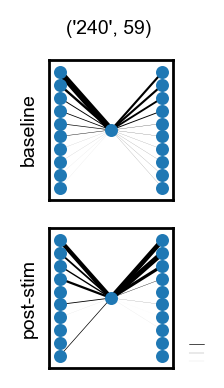

In [48]:
node_size = 15
weight_transform = lambda x: (x**2) * 25

fig, ax = plt.subplots(len(grp), 1, figsize=(0.8, 1 * len(grp)))

for _ax, (_session_type, use_g) in zip(ax, grp.items()):
    weights = np.array([use_g[u][v]["weight"] for (u, v) in use_g.edges()])
    in_nodes = [_ for _ in use_g.nodes() if (_ < 200) and (_ > 0)]
    out_nodes = [_ for _ in use_g.nodes() if _ >= 200]

    start_y = 0
    dist = 5

    in_coords = {
        node: (-5, start_y - (i * dist)) for i, node in enumerate(in_nodes)
    }
    out_coords = {
        node: (+5, start_y - (i * dist)) for i, node in enumerate(out_nodes)
    }
    new_pos = {**in_coords, **out_coords}

    all_coords = np.array(
        [_ for _ in list(in_coords.values()) + list(out_coords.values())]
    )
    new_pos[0] = (0, all_coords.min(axis=0)[1] / 2)

    nx.draw_networkx_edges(
        use_g,
        new_pos,
        width=weight_transform(weights),
        ax=_ax,
        arrows=False,
        arrowsize=1,
    )
    nx.draw_networkx_nodes(use_g, new_pos, node_size=node_size, ax=_ax)

    _ax.set_ylabel(_session_type)

# make a legend
ylimits = _ax.get_ylim()
xlimits = _ax.get_xlim()

# show levels
levels = [0.025, 0.05, 0.1]

xedge = xlimits[1] * 1.5
xlen = (xlimits[1] - xedge) * 0.5

yrange = ylimits[1] - ylimits[0]
ypos = ylimits[0] + (yrange) * 0.05
yinc = yrange * 0.06

for _level in levels:
    _ax.plot(
        [xedge, xedge + xlen],
        [ypos, ypos],
        lw=weight_transform(_level),
        clip_on=False,
        color="k",
    )
    ypos += yinc
_ax.set_xlim(xlimits)
_ax.set_ylim(ylimits)
fig.suptitle(key, fontsize=7)
plt.show()
savefig(
    fig,
    os.path.join(
        os.path.join(figure_cfg["store_dir"], "transition_examples"),
        f"learning_graph_inout_change_{key}",
    ),
    bbox_inches="tight",
)